## Data prep


In [41]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


rates_data = pd.read_json('rates_history.json')
rates_data.head()

,address,name,symbol,decimals,data
0,0xf9a98a9452485ed55cd3ce5260c2b71c9807b11a,ERC4626-Wrapped Lido stETH,wlstETH,18,"{'timestamp': 1666945844, 'apr': {'1d': '5.788..."
1,0xf9a98a9452485ed55cd3ce5260c2b71c9807b11a,ERC4626-Wrapped Lido stETH,wlstETH,18,"{'timestamp': 1667032466, 'apr': {'1d': '5.424..."
2,0xf9a98a9452485ed55cd3ce5260c2b71c9807b11a,ERC4626-Wrapped Lido stETH,wlstETH,18,"{'timestamp': 1667119088, 'apr': {'1d': '5.351..."
3,0xf9a98a9452485ed55cd3ce5260c2b71c9807b11a,ERC4626-Wrapped Lido stETH,wlstETH,18,"{'timestamp': 1667205710, 'apr': {'1d': '5.351..."
4,0xf9a98a9452485ed55cd3ce5260c2b71c9807b11a,ERC4626-Wrapped Lido stETH,wlstETH,18,"{'timestamp': 1667292332, 'apr': {'1d': '5.024..."


In [42]:
data_list = []
data2_list = []

for index, row in rates_data.iterrows():
    data_list.append(row['data']['timestamp'])
    data2_list.append(row['data']['apr']['30d'])

new_df = pd.DataFrame({'timestamp': data_list, 'apr_30d': data2_list})
new_df['apr_30d'] = new_df['apr_30d'].astype(float)/100
new_df['date'] = pd.to_datetime(new_df['timestamp'], unit='s')
print(new_df.head())


    timestamp   apr_30d                date
0  1666945844  0.054088 2022-10-28 08:30:44
1  1667032466  0.054051 2022-10-29 08:34:26
2  1667119088  0.054027 2022-10-30 08:38:08
3  1667205710  0.053954 2022-10-31 08:41:50
4  1667292332  0.053833 2022-11-01 08:45:32


<Axes: title={'center': 'Wrapped Lido stETH - APR 30d'}, xlabel='date'>

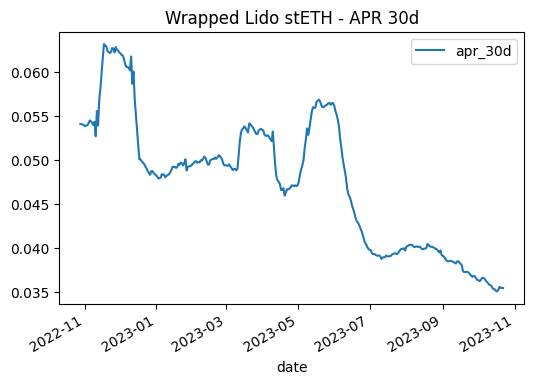

In [57]:

new_df.plot(x='date', y='apr_30d', kind='line', figsize=(6,4), title='Wrapped Lido stETH - APR 30d')


We create a time series for the historical rate of change of the series, and check it's distribution

<Axes: title={'center': 'Wrapped Lido stETH - APR 30d - Change Rate'}, xlabel='date'>

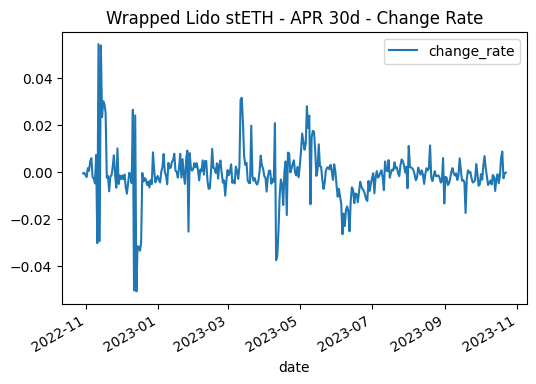

In [58]:
new_df['change_rate'] = new_df['apr_30d'].pct_change()
new_df.plot(x='date', y='change_rate', kind='line', figsize=(6,4), title='Wrapped Lido stETH - APR 30d - Change Rate')


<Axes: title={'center': 'Density Plot for APR Change Rate'}, ylabel='Density'>

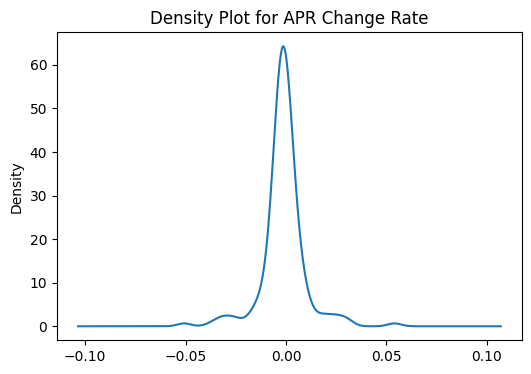

In [45]:
new_df['change_rate'].plot(kind='density', figsize=(6,4),title='Density Plot for APR Change Rate')

   change_rate       CDF
0    -0.050919  0.002793
1    -0.050491  0.005587
2    -0.037620  0.008380
3    -0.035774  0.011173
4    -0.033613  0.013966


<Axes: title={'center': 'CDF Plot for APR Change Rate'}, xlabel='change_rate'>

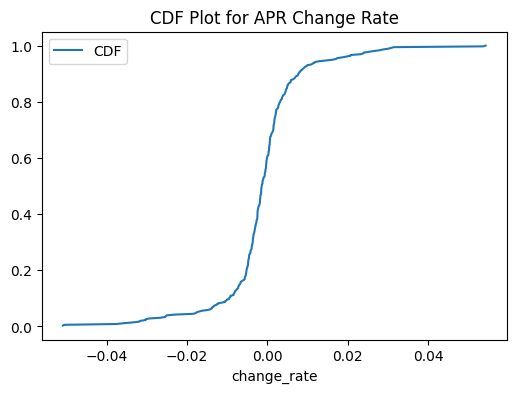

In [59]:
cdf = new_df['change_rate'].value_counts(normalize=True).sort_index().cumsum()
cdf_df = pd.DataFrame({'change_rate': cdf.index, 'CDF': cdf.values})
print(cdf_df.head())
cdf_df.plot(x='change_rate', y='CDF', kind='line', figsize=(6,4), title='CDF Plot for APR Change Rate')


## Random path generation


In [53]:
# Generate a random number between 0 and 1, use it to get the closest change rate from the CDF (which goes from 0 to 1), to produce a synthetic PDF 
def get_random_sample(cdf_df):
    random_sample = np.random.uniform()
    closest_cdf_index = np.abs(cdf_df['CDF'] - random_sample).idxmin()
    closest_change_rate = cdf_df.loc[closest_cdf_index, 'change_rate']
    return closest_change_rate
get_random_sample(cdf_df)


-0.0024161884626999752

In [54]:
def build_random_path(start,length,num_paths,cdf_df):
    random_paths = []
    for i in range(num_paths):
        random_path = []
        for j in range(length):
            if j == 0:
                random_path.append(start)
            else:
                # last item in the random_path list
                last_change_rate = random_path[-1]
                random_change = get_random_sample(cdf_df)
                new_value = last_change_rate*(1+ random_change)
                random_path.append(new_value)
        random_paths.append(random_path)
    return pd.DataFrame(random_paths).transpose()

# sample use
random_df = build_random_path(0.05,360,5,cdf_df)
random_df['date'] = new_df['date']
print(random_df.head())

          0         1         2         3         4                date
0  0.050000  0.050000  0.050000  0.050000  0.050000 2022-10-28 08:30:44
1  0.049806  0.050101  0.049805  0.052690  0.049898 2022-10-29 08:34:26
2  0.048481  0.050052  0.049744  0.052489  0.050010 2022-10-30 08:38:08
3  0.046013  0.049961  0.048595  0.052230  0.050101 2022-10-31 08:41:50
4  0.047117  0.049787  0.048419  0.052710  0.050166 2022-11-01 08:45:32


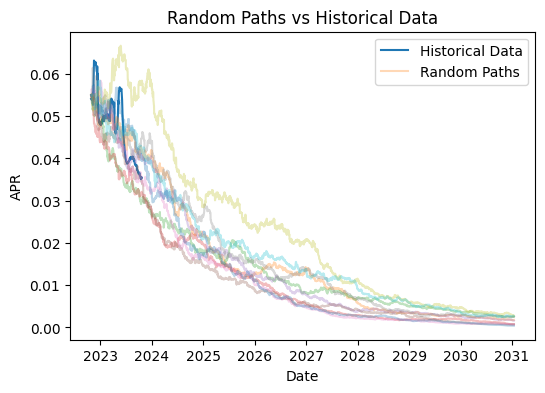

In [55]:
num_paths = 10
starting_rate = 0.055
path_length = 3000
random_df = build_random_path(starting_rate,path_length,num_paths,cdf_df)

# we create dates for the random paths beyond the historical data
date_col_list = new_df['date'].tolist()
while len(date_col_list) < len(random_df):
    last_date = pd.to_datetime(date_col_list[-1])
    next_date = last_date + pd.DateOffset(days=1)
    date_col_list.append(next_date)
date_col = pd.DataFrame(date_col_list, columns=['date'])
random_df['date'] = date_col['date']

# plotting
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(new_df['date'], new_df['apr_30d'], label='Historical Data')
for col in range(num_paths):
    if col > 0:
        ax.plot(random_df['date'],random_df[col],  alpha=0.3)
    else:
        ax.plot(random_df['date'],random_df[col], label='Random Paths',  alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('APR')
ax.set_title('Random Paths vs Historical Data')
ax.legend(loc='upper right')
plt.show()

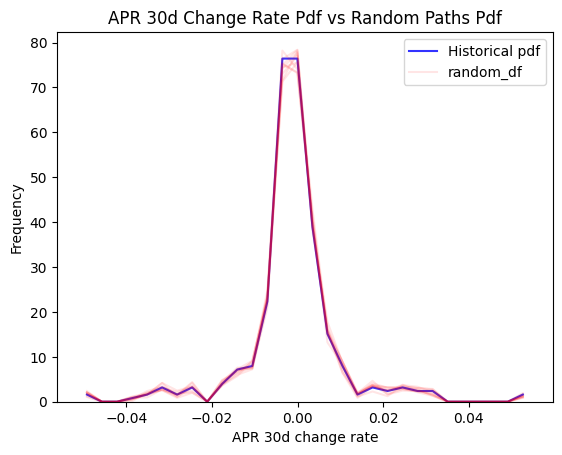

In [56]:
# create the histogram manually for historical data just to get the bins and values and hide it
n, bins, patches = plt.hist(new_df['apr_30d'].pct_change(), bins=30, alpha=0, color='blue',  density=True)
# we display the histogram as a line chart, not bars
bin_centers = 0.5*(bins[1:] + bins[:-1])
plt.plot(bin_centers, n, color='blue', alpha=0.8, label='Historical pdf')

# create the histograms for random_df
for i, col in enumerate(random_df.columns):
    if col != 'date':
        n, bins, patches = plt.hist(random_df[col].pct_change(), bins=30, alpha=0, color='red', density=True)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        plt.plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)

# add labels and title
plt.xlabel('APR 30d change rate')
plt.ylabel('Frequency')
plt.title('APR 30d Change Rate Pdf vs Random Paths Pdf')
plt.legend()
plt.show()


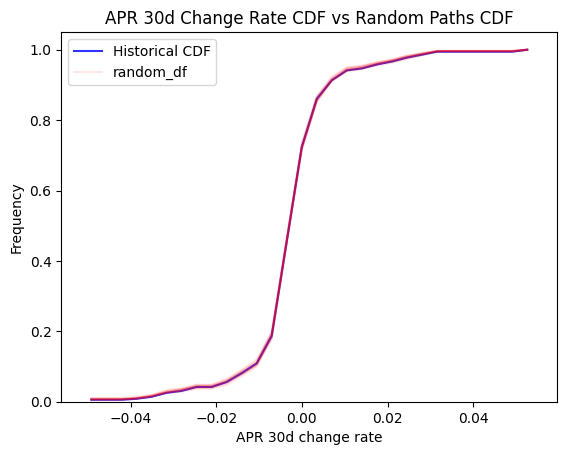

In [51]:
# we also create the CDF manually for historical data just to get the bins and values
n, bins, patches = plt.hist(new_df['apr_30d'].pct_change(), bins=30, alpha=0, color='blue',  density=True, cumulative=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
plt.plot(bin_centers, n, color='blue', alpha=0.8, label='Historical CDF')

# create the CDF for random_df
for i, col in enumerate(random_df.columns):
    if col != 'date':
        n, bins, patches = plt.hist(random_df[col].pct_change(), bins=30, alpha=0, color='red', density=True, cumulative=True)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        plt.plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)

# add labels and title
plt.xlabel('APR 30d change rate')
plt.ylabel('Frequency')
plt.title('APR 30d Change Rate CDF vs Random Paths CDF')
plt.legend()
plt.show()
